# ファインチューニング

入力層に近い部分のパラメータは学習率を小さく、出力層に近い部分のパラメータの学習率は大きく設定。



## 実装の初期準備

In [1]:
import glob
import os.path as osp
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

In [2]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

再現性を確保することができる

In [3]:
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

## DatasetとDataLoaderを作成

In [4]:
class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作。
    画像のサイズをリサイズし、色を標準化。
    訓練時は、データ拡張を行う。
    
    Attributes
    -----------------
    resize : int
        リサイズ先の画像の大きさ
    mean : (R, G, B)
        各色チャネルの平均値
    std : (R, G, B)
        各色チャネルの標準偏差
    """
    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train' : transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'test' : transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase='train'):
        """
        parameters
        --------------
        phase : 'train' or 'test'
        """
        return self.data_transform[phase](img)

元の画像


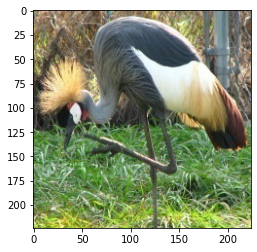

画像処理後


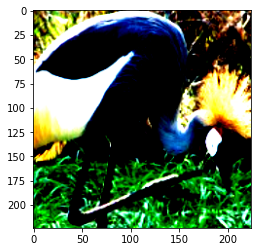

In [5]:
# 動作確認
image_file_path = '../bird-classifier/archive/train/AFRICAN CROWNED CRANE/001.jpg'
img = Image.open(image_file_path)

print("元の画像")
plt.imshow(img)
plt.show()
print('==================================================')

size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase='train')

img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
print('画像処理後')
plt.imshow(img_transformed)
plt.show()

In [6]:
def make_datapath_list(phase="train"):
    """
    データのパスを格納したリストを作成する。
    
    parameters
    -------------------
    phase : 'train' or 'test'
    
    returns
    -------------------
    path_list : list
    """
    
    rootpath = '../bird-classifier/archive/'
    target_path = osp.join(rootpath+phase+'/**/*.jpg')
    print(target_path)
    
    path_list = []
    
    for path in glob.glob(target_path):
        path_list.append(path)
        
    return path_list

train_list = make_datapath_list(phase='train')
test_list = make_datapath_list(phase='test')

# 動作確認
test_list[0:10]

../bird-classifier/archive/train/**/*.jpg
../bird-classifier/archive/test/**/*.jpg


['../bird-classifier/archive/test\\AFRICAN CROWNED CRANE\\1.jpg',
 '../bird-classifier/archive/test\\AFRICAN CROWNED CRANE\\2.jpg',
 '../bird-classifier/archive/test\\AFRICAN CROWNED CRANE\\3.jpg',
 '../bird-classifier/archive/test\\AFRICAN CROWNED CRANE\\4.jpg',
 '../bird-classifier/archive/test\\AFRICAN CROWNED CRANE\\5.jpg',
 '../bird-classifier/archive/test\\AFRICAN FIREFINCH\\1.jpg',
 '../bird-classifier/archive/test\\AFRICAN FIREFINCH\\2.jpg',
 '../bird-classifier/archive/test\\AFRICAN FIREFINCH\\3.jpg',
 '../bird-classifier/archive/test\\AFRICAN FIREFINCH\\4.jpg',
 '../bird-classifier/archive/test\\AFRICAN FIREFINCH\\5.jpg']

In [7]:
class BirdDataset(data.Dataset):
    """
    Attributes
    -----------------
    file_list : リスト
    transform : オブジェクト
    phase : 'train' or 'test'
    """
    
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)
    
    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''
        
        img_path = self.file_list[index]
        img = Image.open(img_path)
        
        label = img_path.split('\\')[1]
        
        img_transformed = self.transform(
            img, self.phase)
        
        bird_list = [p.split('\\')[1] for p in self.file_list]
        bird_list = list(dict.fromkeys(bird_list))
        
        for bird_name in bird_list:
            if label == bird_name:
                label = bird_list.index(bird_name)
                continue
        
        return img_transformed, label
    
    
train_list = make_datapath_list(phase='train')
test_list = make_datapath_list(phase='test')

size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
    
train_dataset = BirdDataset(file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')
test_dataset = BirdDataset(file_list=test_list, transform=ImageTransform(size, mean, std), phase='test')

# 動作確認
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

../bird-classifier/archive/train/**/*.jpg
../bird-classifier/archive/test/**/*.jpg
torch.Size([3, 224, 224])
0


In [8]:
batch_size = 8

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

dataloaders_dict = {"train" : train_dataloader, "test" : test_dataloader}

# 動作確認
batch_iter = iter(dataloaders_dict['train'])
inputs, labels = next(batch_iter)
print(inputs.size())
print(labels)

torch.Size([8, 3, 224, 224])
tensor([155, 228, 153,  53, 169, 261,  43, 162])


## モデルの作成

最後の層だけ構成を変える。

In [10]:
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)

net.classifier[6] = nn.Linear(in_features=4096, out_features=275)

net.train()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## 損失関数の定義

In [11]:
criterion = nn.CrossEntropyLoss()

## 最適化手法を設定

最初に述べたように、各層ごとに学習率を変えられるようにパラメータを設定する。

In [13]:
params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

update_param_names1 = ['features']
update_param_names2 = ['classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight',
                      'classifier.3.weight', 'classifier.3.bias']
update_param_names3 = ['classifier.6.weight', 'classifier.6.bias']

print(update_param_names1)

for name, param in net.named_parameters():
    if update_param_names1[0] in name:
        param.requires_grad = True
        params_to_update_1.append(param)
        print('params_to_update_1に格納', name)
        
    elif name in update_param_names2:
        param.requires_grad = True
        params_to_update_2.append(param)
        print('params_to_update_2に格納', name)
        
    elif name in update_param_names3:
        param.requires_grad = True
        params_to_update_3.append(param)
        print('params_to_update_3に格納', name)
        
    else:
        params.requries_grad = False
        print('勾配計算なし:', name)

['features']
params_to_update_1に格納 features.0.weight
params_to_update_1に格納 features.0.bias
params_to_update_1に格納 features.2.weight
params_to_update_1に格納 features.2.bias
params_to_update_1に格納 features.5.weight
params_to_update_1に格納 features.5.bias
params_to_update_1に格納 features.7.weight
params_to_update_1に格納 features.7.bias
params_to_update_1に格納 features.10.weight
params_to_update_1に格納 features.10.bias
params_to_update_1に格納 features.12.weight
params_to_update_1に格納 features.12.bias
params_to_update_1に格納 features.14.weight
params_to_update_1に格納 features.14.bias
params_to_update_1に格納 features.17.weight
params_to_update_1に格納 features.17.bias
params_to_update_1に格納 features.19.weight
params_to_update_1に格納 features.19.bias
params_to_update_1に格納 features.21.weight
params_to_update_1に格納 features.21.bias
params_to_update_1に格納 features.24.weight
params_to_update_1に格納 features.24.bias
params_to_update_1に格納 features.26.weight
params_to_update_1に格納 features.26.bias
params_to_update_1に格納 features.28.w

In [15]:
optimizer = optim.SGD([
    {'params' : params_to_update_1, 'lr' : 1e-4},
    {'params' : params_to_update_2, 'lr' : 5e-4},
    {'params' : params_to_update_3, 'lr' : 1e-3},
], momentum = 0.9)

## 学習・検証

In [16]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(device)
    
    net.to(device)
    
    for epoch in range(num_epochs):
        print('========================================')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        
        for phase in ['train', 'test']:
            if phase == 'train':
                net.train()
            else:
                net.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            if (epoch == 0) and (phase == 'train'):
                continue
                
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):                    
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects / len(dataloaders_dict[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:4f}'.format(phase, epoch_loss, epoch_acc))

In [17]:
num_epochs = 2
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

cuda


  0%|                                                                                          | 0/172 [00:00<?, ?it/s]

Epoch 1/2


C:\Users\lear0\anaconda3\envs\pytorch_env\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  0%|                                                                                         | 0/4921 [00:00<?, ?it/s]

test Loss: 5.7227 Acc: 0.001455
Epoch 2/2


  1%|▉                                                                                 | 2/172 [00:00<00:13, 12.42it/s]

train Loss: 1.4283 Acc: 0.655497


100%|████████████████████████████████████████████████████████████████████████████████| 172/172 [00:13<00:00, 12.41it/s]

test Loss: 0.2280 Acc: 0.932364
